In [18]:
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import os
import torch.optim as optim
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import gensim.downloader as api
from sklearn.metrics import matthews_corrcoef

In [19]:
# Paths to preprocessed data
train_path = "../prep_data/drug_review_train_auto_prep_full_sc.csv"
val_path = "../prep_data/drug_review_val_auto_prep_full_sc.csv"
test_path = "../prep_data/drug_review_test_auto_prep_full_sc.csv"

# Directory to save models
save_dir = "../checkpoints_lstm"
os.makedirs(save_dir, exist_ok=True)

# Load datasets
def load_data(file_path):
    df = pd.read_csv(file_path)
    df["review"] = df["review"].apply(eval)  # Convert tokenized text from string to list
    
    # Build vocabulary from training set only (to prevent test data leakage)
    return df

df_train = load_data(train_path)
df_val = load_data(val_path)
df_test = load_data(test_path)

# Create vocabulary (from training set only)
word_counts = Counter(word for review in df_train["review"] for word in review)
vocab = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common())}  # Indexing starts from 1

# Convert words to indices
def text_to_indices(df, vocab):
    df["review_idx"] = df["review"].apply(lambda x: [vocab.get(word, 0) for word in x])  # OOV words get index 0
    return df

df_train = text_to_indices(df_train, vocab)
df_val = text_to_indices(df_val, vocab)
df_test = text_to_indices(df_test, vocab)

# Label Mapping
label_mapping = {"Positive": 2, "Neutral": 1, "Negative": 0}
df_train["rating_category"] = df_train["rating_category"].map(label_mapping)
df_val["rating_category"] = df_val["rating_category"].map(label_mapping)
df_test["rating_category"] = df_test["rating_category"].map(label_mapping)

In [20]:
# Padding Function
max_length = 100

def pad_review(review, max_length):
    if len(review) < max_length:
        return review + [0] * (max_length - len(review))  # Pad with 0s
    else:
        return review[:max_length]  # Truncate

df_train["review_idx"] = df_train["review_idx"].apply(lambda x: pad_review(x, max_length))
df_val["review_idx"] = df_val["review_idx"].apply(lambda x: pad_review(x, max_length))
df_test["review_idx"] = df_test["review_idx"].apply(lambda x: pad_review(x, max_length))

# Convert to NumPy arrays
X_train = np.array(df_train["review_idx"].tolist(), dtype=np.float32)
y_train = np.array(df_train["rating_category"])
X_val = np.array(df_val["review_idx"].tolist(), dtype=np.float32)
y_val = np.array(df_val["rating_category"])
X_test = np.array(df_test["review_idx"].tolist(), dtype=np.float32)
y_test = np.array(df_test["rating_category"])

# Apply ADASYN only on the training set
adasyn = ADASYN(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Compute class weights based on the **original training set** (before ADASYN)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("ADASYN applied to training set, and class weights recomputed!")

ADASYN applied to training set, and class weights recomputed!


In [21]:
# Load pre-trained FastText model
fasttext_model = api.load("fasttext-wiki-news-subwords-300")  # Use a medical-specific FastText model if available

# Create embedding matrix
embedding_dim = fasttext_model.vector_size
vocab_size = len(vocab) + 1  # +1 for padding index

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in vocab.items():
    if idx < vocab_size:
        embedding_matrix[idx] = fasttext_model[word] if word in fasttext_model else np.random.normal(scale=0.6, size=(embedding_dim,))

# Convert to PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)

In [22]:
#Define Custom Dataset
class DrugReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = torch.tensor(reviews, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]

# Create train, validation, and test datasets
train_dataset = DrugReviewDataset(X_train_resampled, y_train_resampled)
val_dataset = DrugReviewDataset(X_val, y_val)
test_dataset = DrugReviewDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, config):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=config.get("freeze_embeddings", True), padding_idx=0)
        self.lstm = nn.LSTM(
            config["embedding_dim"], config["hidden_dim"], num_layers=config["num_layers"],
            bidirectional=True, batch_first=True, dropout=config["dropout"]
        )
        self.fc = nn.Linear(config["hidden_dim"] * 2, config["num_classes"])
        self.dropout = nn.Dropout(config["dropout"])
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        hidden_forward = hidden[-2, :, :]
        hidden_backward = hidden[-1, :, :]
        hidden_combined = torch.cat((hidden_forward, hidden_backward), dim=1)  # Combine both directions

        out = self.dropout(self.fc(hidden_combined))
        return self.softmax(out)

In [28]:
# Training Configuration
config = {
    "batch_size": 32,         # Number of samples per batch
    'learning_rate': 0.0036305384307612717,   # Step size for optimizer updates
    "num_epochs": 20,          # Number of times model sees the entire dataset
    "embedding_dim": embedding_dim,     # Size of word embeddings
    'hidden_dim': 128, # Number of LSTM hidden units
    'num_layers': 2,
    "num_classes": 3,         # Output classes (Positive, Neutral, Negative)
    'dropout': 0.2686944352333398,           # Dropout rate to prevent overfitting
    "max_length": 100,        # Max sequence length (padded/truncated)
    "device": "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
}


def save_checkpoint(epoch, model, optimizer, loss, mcc, path):
    """Saves model state, optimizer state, training epoch, and MCC."""
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "loss": loss,
        "mcc": mcc
    }
    torch.save(checkpoint, path)
    print(f"✅ Saved checkpoint at epoch {epoch} → {path}")

def train_model_tqdm(model, train_loader, val_loader, config):
    model.to(config["device"])
    criterion = torch.nn.CrossEntropyLoss().to(config["device"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])

    best_mcc = -1  # Track the best MCC score
    best_checkpoint_path = None  # Track the best checkpoint path

    for epoch in range(1, config["num_epochs"] + 1):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{config['num_epochs']}", leave=True)

        for batch_reviews, batch_labels in progress_bar:
            batch_reviews, batch_labels = batch_reviews.to(config["device"]), batch_labels.to(config["device"])

            optimizer.zero_grad()
            outputs = model(batch_reviews)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item())

        # ✅ Evaluate on validation set every 5 epochs
        if epoch % 5 == 0:
            print(f"🔹 Evaluating on validation set at epoch {epoch}...")
            _, _, _, _, mcc = evaluate_model(model, val_loader, config)

            # ✅ Save checkpoint if this is the best model
            if mcc > best_mcc:
                best_mcc = mcc
                best_checkpoint_path = os.path.join(save_dir, f"best_model_epoch_{epoch}.pt")
                save_checkpoint(epoch, model, optimizer, total_loss, mcc, best_checkpoint_path)

    print(f"\n✅ Training finished. Best model saved at: {best_checkpoint_path}")

def evaluate_model(model, test_loader, config):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])

            outputs = model(inputs)
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=1)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=1)
    mcc = matthews_corrcoef(all_labels, all_preds) if len(set(all_preds)) > 1 else 0

    # Display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print(f"Evaluation - Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | MCC: {mcc:.4f}")

    return accuracy, precision, recall, f1, mcc

In [29]:
# Define objective function for Optuna
def objective(trial):
    # Suggest hyperparameters dynamically
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 64, 256, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)

    # Define model with suggested hyperparameters
    config = {
        "learning_rate": learning_rate,
        "hidden_dim": hidden_dim,
        "embedding_dim": embedding_dim,
        "num_layers": num_layers,
        "dropout": dropout,
        "num_epochs": 5,
        "num_classes": 3,         # Output classes (Positive, Neutral, Negative)
        "max_length": 100,        # Max sequence length (padded/truncated)
        "device": "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
    }

    model = LSTMClassifier(vocab_size=len(vocab), embedding_matrix=embedding_matrix, config=config).to(config["device"])
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss().to(config["device"])

    # Train model
    train_model_tqdm(model, train_loader, config)

    # Evaluate performance
    accuracy, precision, recall, f1, mcc = evaluate_model(model, test_loader, config)

    return mcc  # Optimize MCC

Epoch 5/20: 100%|██████████| 6175/6175 [12:24<00:00,  8.30it/s, loss=0.561]


🔹 Evaluating on validation set at epoch 5...


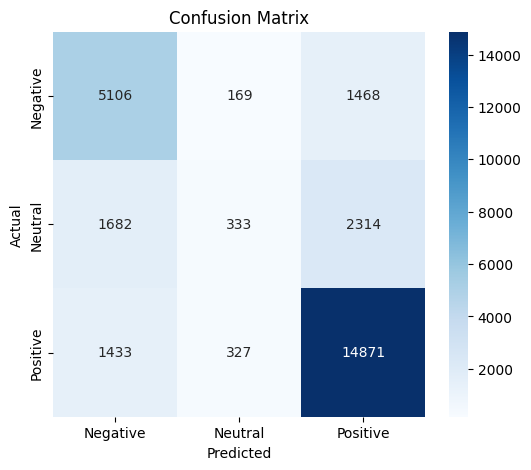

Evaluation - Acc: 0.7331 | Prec: 0.6926 | Rec: 0.7331 | F1: 0.6923 | MCC: 0.4996
✅ Saved checkpoint at epoch 5 → ../checkpoints_lstm\best_model_epoch_5.pt


Epoch 10/20: 100%|██████████| 6175/6175 [12:10<00:00,  8.45it/s, loss=0.759]


🔹 Evaluating on validation set at epoch 10...


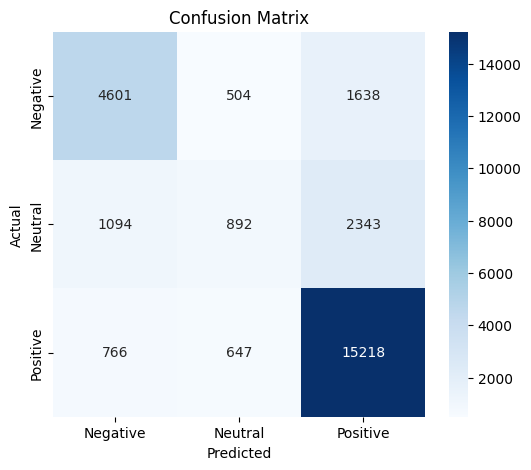

Evaluation - Acc: 0.7476 | Prec: 0.7174 | Rec: 0.7476 | F1: 0.7233 | MCC: 0.5207
✅ Saved checkpoint at epoch 10 → ../checkpoints_lstm\best_model_epoch_10.pt


Epoch 15/20: 100%|██████████| 6175/6175 [12:06<00:00,  8.50it/s, loss=0.828]


🔹 Evaluating on validation set at epoch 15...


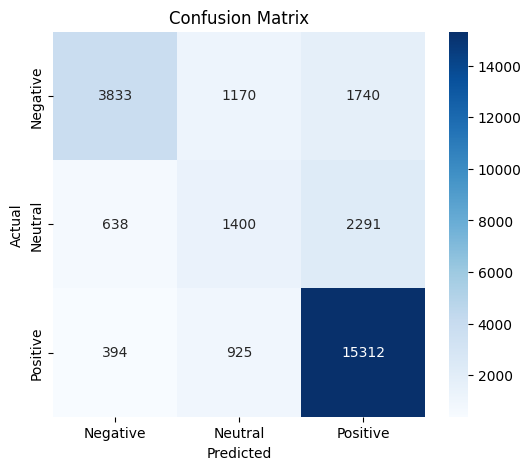

Evaluation - Acc: 0.7416 | Prec: 0.7296 | Rec: 0.7416 | F1: 0.7277 | MCC: 0.5110


Epoch 20/20: 100%|██████████| 6175/6175 [12:03<00:00,  8.53it/s, loss=0.829]


🔹 Evaluating on validation set at epoch 20...


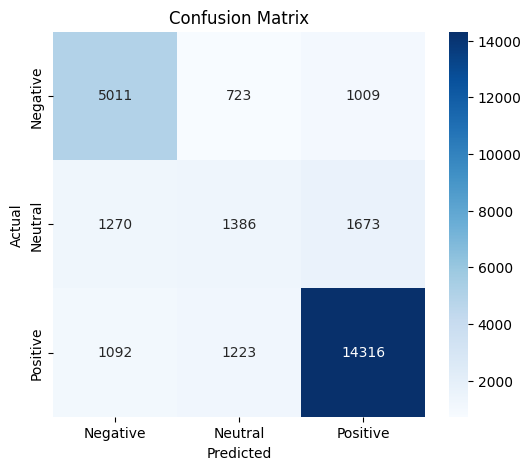

Evaluation - Acc: 0.7477 | Prec: 0.7360 | Rec: 0.7477 | F1: 0.7405 | MCC: 0.5407
✅ Saved checkpoint at epoch 20 → ../checkpoints_lstm\best_model_epoch_20.pt

✅ Training finished. Best model saved at: ../checkpoints_lstm\best_model_epoch_20.pt


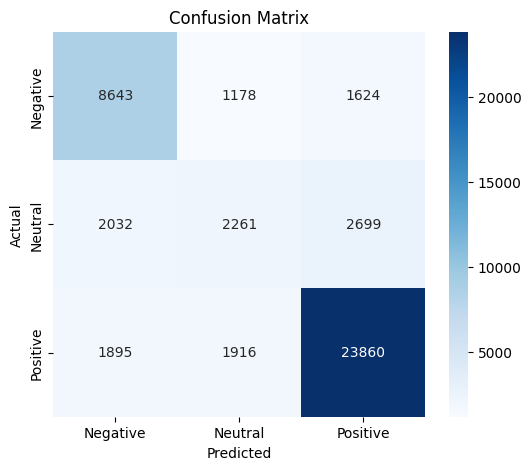

Evaluation - Acc: 0.7540 | Prec: 0.7428 | Rec: 0.7540 | F1: 0.7469 | MCC: 0.5520


(0.7539689424828663,
 0.7427816310958678,
 0.7539689424828663,
 0.7469455055256482,
 0.5520107161482929)

In [30]:
# Create Dataset and DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)


# # Initialize Model
vocab_size = len(vocab)
model = LSTMClassifier(vocab_size, embedding_matrix, config).to(config["device"])
# # Run Optuna optimization
# study = optuna.create_study(direction="maximize")  # Maximizing accuracy
# study.optimize(objective, n_trials=7)

# # Print best hyperparameters 
# print("Best Hyperparameters:", study.best_params)
# Train and Evaluate
train_model_tqdm(model, train_loader, val_loader, config)
evaluate_model(model, test_loader, config)